In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

## Load the data - it is encoded in cp1252.

In [2]:
df = pd.read_csv('/kaggle/input/democratic-debate-transcripts-2020/debate_transcripts_v3_2020-02-26.csv', encoding='cp1252')
df['date'] = pd.to_datetime(df.date)
df.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds
0,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Good evening and welcome, the Democratic presi...",8.0
1,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And Super Tuesday is just a week away and this...,22.0
2,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,And CBS News is proud to bring you this debate...,14.0
3,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Gayle King,And we are partnering tonight also with Twitte...,10.0
4,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Norah O’Donnell,"Now, here are the rules for the next two hours...",31.0


## Speakers who are candidates still in the race:
- Joe Biden
- Elizabeth Warren
- Bernie Sanders
- Pete Buttigieg
- Amy Klobuchar
- Michael Bloomberg
- Tom Steyer
- Tulsi Gabbard

## Filter to only the above mentioned candidates

In [3]:
df = df.loc[df.speaker.isin({'Joe Biden', 'Elizabeth Warren', 'Bernie Sanders', 'Pete Buttigieg', 'Amy Klobuchar', 'Michael Bloomberg', 'Tom Steyer', 'Tulsi Gabbard'})]
df.speaker.value_counts()

Joe Biden            456
Elizabeth Warren     440
Bernie Sanders       430
Pete Buttigieg       392
Amy Klobuchar        353
Tom Steyer           144
Michael Bloomberg     97
Tulsi Gabbard         77
Name: speaker, dtype: int64

## Speaking Time EDA

### Candidate Speaking Time

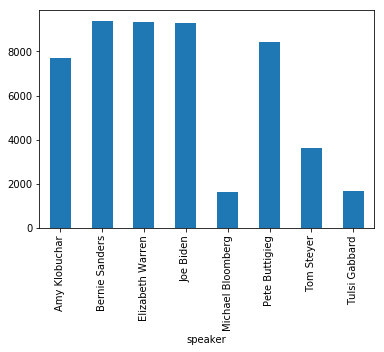

In [4]:
df.groupby(by='speaker').speaking_time_seconds.sum().plot.bar()
plt.show()

### Candidate Speaking Time over time

In [5]:
# Multi-Index on debate, candidate
debate_candidate_time = df.groupby(by=['date', 'speaker']).speaking_time_seconds.sum()
# Most recent debate
debate_candidate_time['2020-02-25']

speaker
Amy Klobuchar        803.0
Bernie Sanders       911.0
Elizabeth Warren     768.0
Joe Biden            765.0
Michael Bloomberg    822.0
Pete Buttigieg       774.0
Tom Steyer           414.0
Name: speaking_time_seconds, dtype: float64

In [6]:
# Multi-Index on candidate, debate
candidate_debate_time = df.groupby(by=['speaker', 'date']).speaking_time_seconds.sum()
candidate_debate_time

speaker        date      
Amy Klobuchar  2019-06-26      0.0
               2019-07-30    635.0
               2019-09-12    630.0
               2019-10-15    804.0
               2019-11-20    647.0
                             ...  
Tom Steyer     2020-02-25    414.0
Tulsi Gabbard  2019-06-26      0.0
               2019-07-31    634.0
               2019-10-15    501.0
               2019-11-20    555.0
Name: speaking_time_seconds, Length: 62, dtype: float64

In [7]:
# Print Median Speaking Times
for candidate in df.speaker.unique():
    med = round(candidate_debate_time[candidate].median()/60)
    print(f'{candidate}: {med} minutes (median)')

Bernie Sanders: 15 minutes (median)
Michael Bloomberg: 13 minutes (median)
Pete Buttigieg: 13 minutes (median)
Elizabeth Warren: 16 minutes (median)
Tom Steyer: 10 minutes (median)
Joe Biden: 15 minutes (median)
Amy Klobuchar: 13 minutes (median)
Tulsi Gabbard: 9 minutes (median)


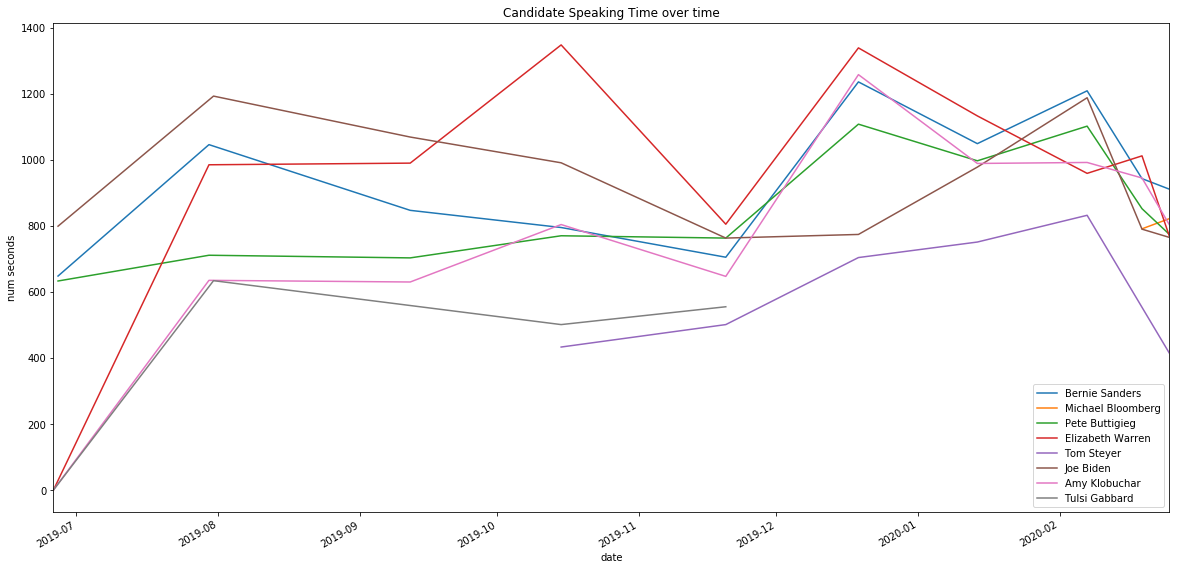

In [8]:
# Plot Speaking Times Line Graph
plt.figure(figsize=(20,10))
for candidate in df.speaker.unique():
    candidate_debate_time[candidate].plot(label=candidate)
plt.legend()
plt.xlabel('date')
plt.ylabel('num seconds')
plt.title('Candidate Speaking Time over time')
plt.show()

We can see that Elizabeth Warren is given the most time to speak, followed by Bernie Sanders and Joe Biden, then Buttigieg, Klobuchar, and Bloomberg.

We can see that Sanders has had the majority of speaking time recently, and despite his just recent entry into the race, Michael Bloomberg spoke for the second longest time in the recent debate.

Surprisingly, Amy Klobuchar has quite a bit of speaking time despite her low performance in the polls.

## Define Methods for Parsing the texts
- I will be using `spaCy` as I have found their parsing to be quick and accurate.

Our goal will be to turn a document into a list of terms. I will not be using a DNN like *Bert*, and therefore will be doing a good deal of preprocessing, including stop word removal, lemmatization, and noun chunk/entity merging.

In [9]:
import spacy

nlp = spacy.load('en_core_web_sm')

In [10]:
# I add additional stops that lead to lower quality topics
additional_stops = {'things', 'way', 'sure', 'thing', 'question', 'able', 'point', 'lot', 'time'}

In [11]:
from spacy.util import filter_spans


def _remove_stops(span):
    while span and span[0].pos_ not in {'ADJ', 'NOUN', 'PROPN'}:
        span = span.doc[span.start+1:span.end]
    return span


# Resource: 
# https://github.com/explosion/spacy/blob/master/examples/information_extraction/entity_relations.py
def merge_ents_and_nc(doc):
    spans = list(doc.ents) + list(doc.noun_chunks)
    spans = list(map(_remove_stops, spans))
    spans = filter_spans(spans)
    with doc.retokenize() as retokenizer:
        for span in spans:
            if span:
                # Added this in from the code - need to lemmatize better and keep ent types
                root = span.root
                attrs = {'LEMMA': span.text.lower(), 'POS': root.pos_, 'ENT_TYPE': root.ent_type_}
                retokenizer.merge(span, attrs=attrs)


def to_terms_list(doc):
    merge_ents_and_nc(doc)
    return [term.lemma_ for term in doc if len(term.lemma_) > 2 and\
             not term.is_stop and\
             term.pos_ in {'NOUN', 'PROPN', 'ADJ'} and\
             term.lemma_ not in additional_stops and\
             "crosstalk" not in term.lower_]

## Simple is Better than Complex. My Simple Idea with Topic Modeling
1. Create a Corpus of Documents from `df.speech.values`
2. Most Frequent Terms by Speaker
3. Vectorize using `sklearn.feature_extraction.text.TfidfVectorizer`, using parsed documents as output from `to_terms_list` as input
4. Use NMF Topic Model, `sklearn.decomposition.NMF`, to break our corpus into `N` topics.

In [12]:
from spacy.tokens.doc import Doc

corpus = list(nlp.pipe(df.speech.values, n_threads=4))

In [13]:
terms = [to_terms_list(doc) for doc in corpus]
df['terms'] = terms

In [14]:
import itertools
from collections import Counter

def most_frequent(terms, k):
    flat_terms = list(itertools.chain(*terms))
    return Counter(flat_terms).most_common(k)

In [15]:
mf = df.groupby(by='speaker').terms.apply(lambda terms: most_frequent(terms, 10))
speakers = mf.index
top_terms = mf.values
for s, tt in zip(speakers, top_terms):
    print(f"{s}: {tt}\n")

Amy Klobuchar: [('people', 133), ('president', 102), ('country', 56), ('donald trump', 47), ('bill', 39), ('america', 37), ('state', 27), ('money', 25), ('work', 20), ('stage', 20)]

Bernie Sanders: [('people', 179), ('country', 105), ('healthcare', 63), ('america', 52), ('medicare', 48), ('american people', 42), ('world', 42), ('trump', 42), ('president', 40), ('joe', 39)]

Elizabeth Warren: [('people', 195), ('country', 82), ('america', 80), ('president', 42), ('money', 42), ('donald trump', 35), ('healthcare', 35), ('democrats', 35), ('families', 35), ('stage', 29)]

Joe Biden: [('fact', 186), ('people', 109), ('president', 81), ('number', 66), ('country', 40), ('world', 40), ('deal', 32), ('plan', 32), ('years', 28), ('position', 26)]

Michael Bloomberg: [('people', 24), ('new york city', 16), ('senator', 11), ('donald trump', 10), ('country', 10), ('money', 10), ('years', 8), ('president', 7), ('job', 7), ('right', 7)]

Pete Buttigieg: [('president', 110), ('country', 75), ('peopl

Notice how the most successful candidate, Bernie Sanders, speaks less about Donald Trump and focuses much more on healthcare, medicare, and the american people.

Compare this to second tier candidates like Buttigieg and Klobuchar who have "president" or "donald trump" surface higher in their most frequent terms.

## Topic Modeling
I take a heuristic approach to topic modeling, and have executed the below cells a few times to find a suitable value for `N`. I look for a mix of granularity and qualitative meaning.

After iterative attempts, I chose **8** topics, and I do a human pass through to summarize them. One particularly great approach for helping decide the number of topics is *Stability*, as seen in the paper: *[How Many Topics? Stability Analysis for Topic Models*](https://arxiv.org/pdf/1404.4606.pdf). I need to clean up my code for that, and will implement it here in the coming days, stay tuned...

In [16]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.decomposition import NMF

# Useful hack: this dummy allows us to use our extracted terms from the methods above, overriding sklearn's tokenizer.
dummy = lambda x: x

vectorizer = TfidfVectorizer(max_df=0.5, min_df=10, preprocessor=dummy, tokenizer=dummy, ngram_range=(1,2))
features = vectorizer.fit_transform(terms)

## About NMF:
**NMF** stands for **Non-negative Matrix Factorization** and it is a form of dimensionality reduction. 

The idea is:

Given some non-negative matrix $X$, find two matrices, $W$ and $H$, such that $W\cdot H \approx X$   

Without getting too deep into the math, here is a high level leyman's overview of what happens:

1. Initialize matrices $W$ and $H$ with random values.
2. Perform $W \cdot H$ and compare the values to the original matrix X
3. Now, adjust these values incrementally through a number of iterations to optimize.


The output of this is the matrices $W$ and $H$. In the case of text processing where $X$ is some matrix containing text feature weights, these represent the 'document-topic matrix' and 'topic-term matrix' respectively.

The 'document-topic matrix', or `doc_topic_matrix` in our code, has the shape `len(corpus), n_topics` and represents the topic distribution for each document.

The 'topic-term matrix', `topic_term_matrix` in our code, has the shape `n_topics, len(terms)`, and represents the term distribtuion for each topic, i.e. topic 0 consists dominantly of terms A, B, C, ...

In [17]:
N=8
tm = NMF(n_components=N)
doc_topic_matrix = tm.fit_transform(features)
topic_term_matrix = tm.components_
terms = vectorizer.get_feature_names()

# Array where rows are docs, columns are topics
print(doc_topic_matrix.shape)

(2389, 8)


In [18]:
def top_topic_terms(topic_term_matrix, i, n_terms=10):
    topic = topic_term_matrix[i]
    return [(terms[idx], topic[idx]) for idx in np.argsort(topic)[::-1][:n_terms]]

In [19]:
for i in range(N):
    print(i)
    print(top_topic_terms(topic_term_matrix, i))

0
[('people', 3.3077405613713307), ('america', 0.27338801688902203), ('government', 0.1908463385344917), ('people people', 0.1828897380127292), ('people country', 0.13978498724519678), ('lives', 0.13692669101644975), ('place', 0.12576790167660806), ('healthcare', 0.11257941628564895), ('democrats', 0.1060778361419162), ('americans', 0.10018962290351986)]
1
[('president', 2.049013660571809), ('united states', 0.3464436274091054), ('president united states', 0.30183062325959786), ('stage', 0.15264808400385746), ('case', 0.12867358491484127), ('law', 0.12096794517521464), ('congress', 0.11987000821032207), ('washington', 0.10076974151180756), ('russia', 0.09613347351782972), ('allies', 0.09518776619133053)]
2
[('fact', 2.34102310645208), ('matter', 0.40533250792370107), ('number', 0.3146705455063268), ('fact matter', 0.31216302095017195), ('clear', 0.29217414664102237), ('man', 0.22772056694921872), ('price', 0.16225775475527887), ('matter fact', 0.15525847881828467), ('deal', 0.154674508

In [20]:
names = {0: 'The American People',
         1: 'The President of the United States',
         2: 'Biden Telling us what he is saying is a matter of fact',
         3: 'The American Country',
         4: 'Global Diplomatic Issues',
         5: 'Social/Constitutional Rights',
         6: 'Healthcare and Medicare',
         7: 'Donald Trump'}

In [21]:
for i in range(N):
    col = f"topic_{i}"
    df[col] = doc_topic_matrix[:,i]
df.head()

,date,debate_name,debate_section,speaker,speech,speaking_time_seconds,terms,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
5,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,"Well, you’re right, the economy is doing reall...",59.0,"[right, economy, great, people, mr. bloomberg,...",0.107226,0.000000,0.001837,0.095823,0.000000,0.066448,0.002088,0.002068
6,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Michael Bloomberg,Senator-,5.0,[senator-],0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
8,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Michael Bloomberg,I think that Donald Trump thinks it would be b...,19.0,"[donald trump, well, president, vladimir putin...",0.000000,0.214028,0.000000,0.000000,0.000000,0.000000,0.000000,0.237277
9,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Bernie Sanders,"Oh, Mr. Bloomberg. Let me tell Mr. Putin. Okay...",27.0,"[mr. bloomberg, mr. putin, good friend, presid...",0.006303,0.157056,0.004502,0.011880,0.024692,0.000000,0.007765,0.011023
11,2020-02-25,South Carolina Democratic Debate Transcript: F...,Part 1: South Carolina Democratic Debate Trans...,Pete Buttigieg,We know what the President … what Russia wants...,3.0,"[president, russia, chaos]",0.000000,0.221029,0.000000,0.000000,0.003885,0.000000,0.000000,0.000000


In [22]:
def percent_comp(x):
    return x/x.sum()

## Speaker-Topic DataFrame
I create a `pandas.DataFrame` to display: for each speaker, their total weight in each topic.
This can help answer two things:
1. If we apply `percent_comp`, the percent composition on each row, we get the percentage each candidate talks about each topic - which topics they focus on.
2. If we apply `percent_comp` on each column, we'll see who dominates a topic.

In [23]:
df_speaker_topics = df.groupby(by=['speaker'])[df.columns[-N:]].sum()
df_speaker_topics

,topic_0,topic_1,topic_2,topic_3,topic_4,topic_5,topic_6,topic_7
speaker,,,,,,,,
Amy Klobuchar,7.650797,11.547626,1.811222,7.795020,4.426998,2.367170,5.892472,7.588296
Bernie Sanders,8.674468,4.092695,3.286723,14.275556,8.299994,4.739910,10.433126,4.129244
Elizabeth Warren,10.385560,4.669186,2.005828,10.736469,6.938798,2.387871,8.379050,8.397786
Joe Biden,5.518507,9.306664,18.447532,5.191198,6.834613,3.591125,7.502055,4.836129
Michael Bloomberg,1.076053,0.954638,0.676380,1.620823,1.002424,1.251455,1.634326,1.517536
Pete Buttigieg,3.442054,12.040171,3.308789,11.444541,5.451900,3.838414,5.914650,5.476982
Tom Steyer,2.047134,1.923601,2.785090,3.953023,3.349870,3.131720,1.973765,2.174290
Tulsi Gabbard,1.325632,2.304739,0.774535,3.726768,1.153659,0.255148,0.803951,1.206597


## Percent of Topic, by Candidate
Show, for each topic, which candidates talk about it the most, by the above `df_speaker_topics`

The American People
people | america | government | people people | people country | lives | place | healthcare | democrats | americans


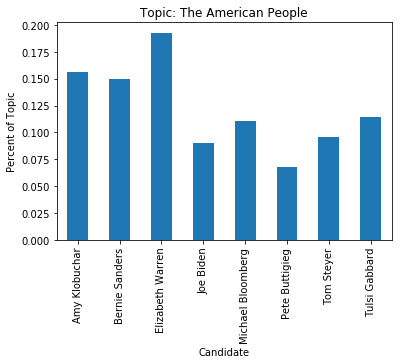

The President of the United States
president | united states | president united states | stage | case | law | congress | washington | russia | allies


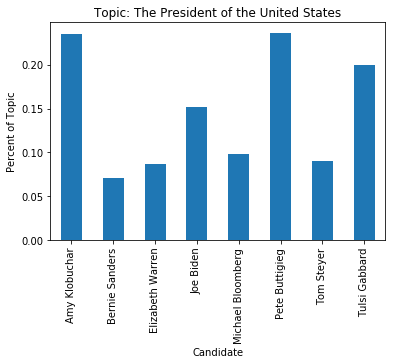

Biden Telling us what he is saying is a matter of fact
fact | matter | number | fact matter | clear | man | price | matter fact | deal | senator


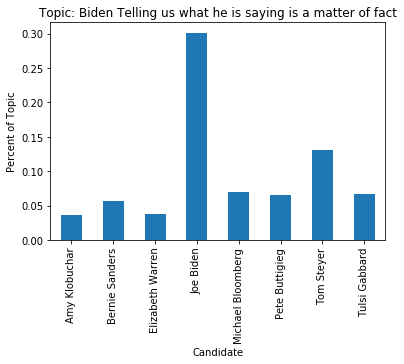

The American Country
country | american people | america | healthcare | people country | economy | future | state | today | government


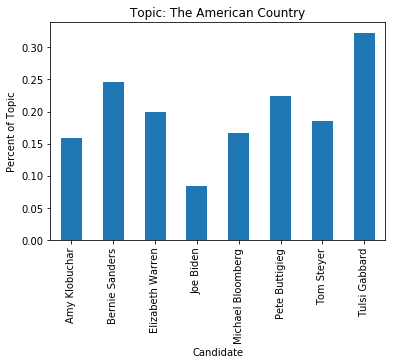

Global Diplomatic Issues
world | america | allies | china | iran | climate change | rest | united states | rest world | problem


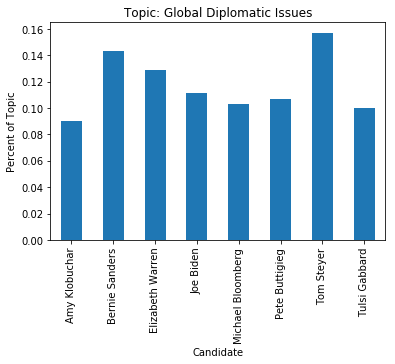

Social/Constitutional Rights
right | woman | american people | wrong | court | politicians | government | family | constitution | democracy


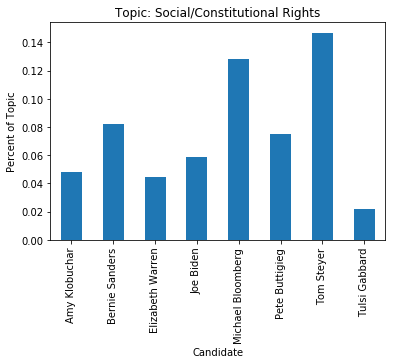

Healthcare and Medicare
money | plan | medicare | healthcare | year | years | family | bill | premiums | public option


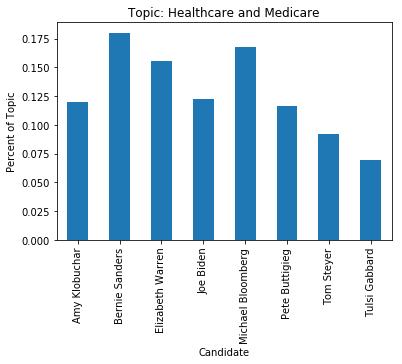

Donald Trump
donald trump | democrats | families | trump | stage | house | candidate | wealthy | donald trump donald trump | mayor bloomberg


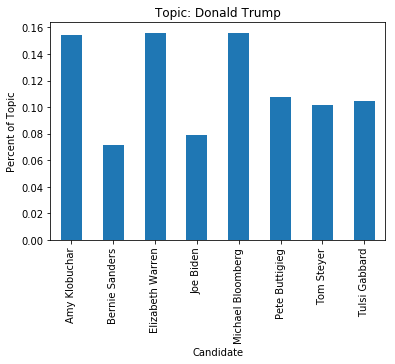

In [24]:
import matplotlib.pyplot as plt

topic_speaker_dist = df_speaker_topics.apply(percent_comp, axis=1)

for i, topic in enumerate(topic_term_matrix):
    print(names[i])
    print(' | '.join(terms[idx] for idx in np.argsort(topic)[::-1][:10]))
    topic_speaker_dist[f'topic_{i}'].plot.bar()
    plt.title(f'Topic: {names[i]}')
    plt.xlabel('Candidate')
    plt.ylabel('Percent of Topic')
    plt.show()